In [98]:
#This program takes about 60 minutes to run
#Loading Package
import os

import time
import numpy as np
import scipy as sci
import scipy.io as sio
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras


from numpy.random import seed
seed(100)


import matplotlib.pyplot as plt
from IPython.display import clear_output


In [99]:
# load raw data
DATA_FOLDER = './Data'
raw = pd.read_csv(os.path.join('Implied_Volatility_Data_vFinal.csv'), parse_dates= ["Date"])
# check the raw data
print("Size of the dataset (row, col): ", raw.shape)
raw.head(2)

Size of the dataset (row, col):  (125700, 5)


,Date,SPX Return,Time to Maturity in Year,Delta,Implied Volatility Change
0,2014-06-30,0.006678,0.184,0.745927,0.008462
1,2014-06-30,0.006678,2.252,0.286911,0.002024


In [100]:
raw.tail(2)

,Date,SPX Return,Time to Maturity in Year,Delta,Implied Volatility Change
125698,2019-06-26,0.003823,0.340,0.917499,0.006153
125699,2019-06-26,0.003823,1.476,0.721438,-0.000285


# Q6.15

## Adding the VIX index

In [101]:
vix = pd.read_csv(os.path.join('VIX.csv'), parse_dates= ["Date"], infer_datetime_format=True)
vix.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-06-30,11.75,11.81,11.30,11.57,11.57,0
1,2014-07-01,11.28,11.42,10.92,11.15,11.15,0


In [102]:
raw_with_vix = raw.merge(vix["Adj Close"], how="left", left_on= raw["Date"], right_on = vix["Date"] )
raw_with_vix.rename(columns={"Adj Close": "VIX Close"}, inplace = True)
raw_with_vix = raw_with_vix.iloc[:,1:]

In [103]:
raw_with_vix.head(5)

,Date,SPX Return,Time to Maturity in Year,Delta,Implied Volatility Change,VIX Close
0,2014-06-30,0.006678,0.184,0.745927,0.008462,11.57
1,2014-06-30,0.006678,2.252,0.286911,0.002024,11.57
2,2014-06-30,0.006678,0.124,0.902941,0.019707,11.57
3,2014-06-30,0.006678,2.144,0.910926,0.006424,11.57
4,2014-06-30,0.006678,1.412,0.885760,0.005673,11.57


## Construct the 3 variables for Regression Approach

In [125]:
## Expected change in implied volatility: R (SIMPLE ML MODEL p150)

# For simplicity, assigned variable raw with vix to raw
raw = raw_with_vix

# construct the 3 variables for regression
raw['x1'] = raw['SPX Return'] / np.sqrt(raw['Time to Maturity in Year'])
raw['x2'] = raw['SPX Return'] / np.sqrt(raw['Time to Maturity in Year']) * raw['Delta']
raw['x3'] = raw['x2'] * raw['Delta']

# Put the X and Y variable in data frame for regression
y = raw['Implied Volatility Change']
X = raw[['x1', 'x2', 'x3','SPX Return','Time to Maturity in Year','Delta']]
X_V= raw[['x1', 'x2', 'x3','SPX Return','Time to Maturity in Year','Delta','VIX Close']]

In [126]:
# BASE========================================================================================

# Divide data into training set and test set(note that random seed is set)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

# Divide training set into training and validation set
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.25,random_state=100)


# Training NN With VIX=========================================================================
# To benchmark I added v as a suffix to compare the models

# Divide data into training set and test set(note that random seed is set)
Xv_train,Xv_test,yv_train,yv_test=train_test_split(X_V,y,test_size=0.2,random_state=100)

# Divide training set into training and validation set
Xv_train,Xv_val,yv_train,yv_val=train_test_split(X_train,y_train,test_size=0.25,random_state=100)

In [124]:
# BASE========================================================================================

# Scale features based on Z-Score
scaler = StandardScaler()
scaler.fit(X_train)


X_scaled_train = scaler.transform(X_train)
X_scaled_vals = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

# Run the regression on the training data
lr = LinearRegression(fit_intercept=False)
lr.fit(X_scaled_train[:,:3], y_train)

# Get the prediction
y_pred = lr.predict(X_scaled_test[:,:3])

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

print('Test loss (MSE):', mse)

Test loss (MSE): 7.423167462421238e-05


## ML Approach

In [109]:
# Create ML Model
# Sequential function allows you to define your Neural Network in sequential order
# Within Sequential, use Dense function to define number of nodes, activation function and other related parameters 
# For more information regrading to activation functoin, please refer to https://keras.io/activations/
model = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (3,)),
                                 Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                Dense(1)])

# Model summary function shows what you created in the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                80        
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 941
Trainable params: 941
Non-trainable params: 0
_________________________________________________________________


In [110]:
# Complie function allows you to choose your measure of loss and optimzer
# For other optimizer, please refer to https://keras.io/optimizers/
model.compile(loss = "mse",optimizer = "Adam")

In [11]:
# Checkpoint function is used here to periodically save a copy of the model. 
# Currently it is set to save the best performing model
checkpoint_cb = keras.callbacks.ModelCheckpoint("implied_vol_model_vFinal.h5",save_best_only = True)

# Early stopping allows you to stop your training early if no improvment is shown after cerain period
# Currently it is set at if no improvement occured in 1000 epochs, at the stop the model will also revert back to the best weight
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 1000,restore_best_weights = True)

# Remark: checkpoint could be redundant here as early stopping function can also help restoring to the best weight
# We put both here just to illustrate different ways to keep the best model
 

In [120]:
# train your model
# The fit function allows you to train a NN model. Here we have training data, number of epochs,batch size, validation data, 
# and callbacks as input
# Callback is an optional parameters that allow you to enable tricks for training such as early stopping and checkpoint

# Remarks: Altough we put 50000 epochs here, the model will stop its training once our early stopping criterion is triggered

history=model.fit(X_scaled_train[:,3:6],y_train,epochs=100, batch_size = 128, verbose = 0, validation_data=(X_scaled_vals[:,3:6],y_val),
                 callbacks=[checkpoint_cb, early_stopping_cb])






In [121]:
# Load the best model you saved and calcuate MSE for testing set

model = keras.models.load_model("implied_vol_model_vFinal.h5")
mse_test = model.evaluate(X_scaled_test[:,3:6],y_test,verbose=0)

print('Test Loss(MSE):', mse_test)

Test Loss(MSE): 6.492684769909829e-05


In [122]:
# Calculate Gain Ratio

gain = 1 - mse_test/mse 

print('Gain Ratio:', gain)

Gain Ratio: 0.12534847115087322


## Review your results and export training history


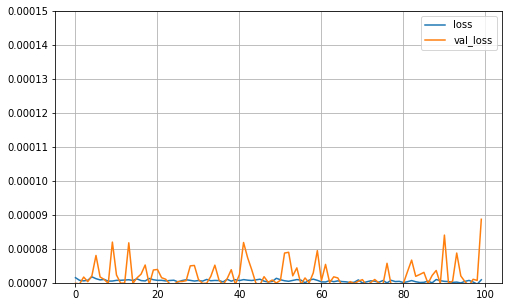

In [123]:
# Plot training history

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.00007,0.00015)
plt.show()

#Export your training history for MSE
output = pd.DataFrame(history.history)
# output.to_csv("mse_overtime.csv")